<a href="https://colab.research.google.com/github/DigitalHugManitees/DH_Topic_Workshop/blob/main/LDA_with_ngrams_on_Colab_v28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA using Spacey and Gensim 
## with n-grams for more accurate topics

This notebook provides topics based on documents within a large collection of documents, called a corpus. LDA, or Latent Dirichlet Allocation, is a statistical model that provides probabilities of words belonging to a topic, with the assumption that a document contains a small number of topics. 


### Limitations
- [ ] Still lots of human level interpretation needed - there are lots of terms that are contextual.
- [ ] Data needs to be a corpus, so is one newspaper a corpus of topics? Or a bunch of newspapers? How do you define your corpus?
- [ ] You will need to know how many topics you want beforehand. 
- [ ] The output is non-deterministic, meaning that you may see a different result each time you run the analysis. The assignment of nominal cluster numbers is less important than their relationship to each other. 

### development
- [ ] is it possible to automate dividing up a newspaper/gazette by its articles, so that one issue may be a corpus of many articles? 
- [ ] or do we work on a larger scale and years of Gazette are lumped together with many years forming a corpus?

### sources on LDA
 - https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2


### Authors and affiliations:
This notebook is based off a tutorial by Tarek Ghanoum (https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf).
It was modified by Anika Nissen (University of Duisburg-Essen (UDE)https://www.iis.wiwi.uni-due.de/team/anika-nissen/) with help from Dominic Rosati (scite.ai, https://scite.ai/authors/domenic-rosati-X4xWR8A) for improvement of the ngrams. 
Additional modifications by Poppy Riddle (Dalhousie University, https://github.com/poppy-nicolette) for deployment on Colab, collating files, annotating, assigning clusters to source files in the df, and exporting. 




## Step 1: Mount your Google Drive to Colab so that files can be saved. 
<br>
This will create a working directory that you can place files in for analyzing, and then download output files.

In [2]:
#mount google drive here
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os 

# Set your working directory to a folder in your Google Drive. 
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved AND
# what you want the folder to be called. This is your working directory
project_folder = "Colab Notebooks/LDA_Project_Folder/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # let the user know that the working directory was changed
  print('\nYour working directory was changed to ' + root_dir + project_folder)
  print("You can also run !pwd to confirm the current working directory.")

create_and_set_working_directory(project_folder)

#source: modified from https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/

Mounted at /content/drive

Your working directory was changed to /content/drive/My Drive/Colab Notebooks/LDA_Project_Folder/
You can also run !pwd to confirm the current working directory.


## Allow Google Colab to connect to your Drive
The following cell will establish a connection between Google Colab and your Drive. A pop-up will ask for which Google account and also ask permission. 

Google also provides links to sources explaining how your data is used and shared across these two services. 

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

### Now, you have a working directory!
Remember those .txt files you saved from the OCR notebook? Locate them. 
 <br>Then, go to your Google Drive and locate the LDA_Project_Folder you created in the cells above.
 <br>Move the .txt files to this Google folder (your working directory).
<br>You will repeat this process with every group of .txt files you want to analyze.

## Step 2: Install libraries and dependencies
This will install and import all of the libraries needed. <br>
It will also import our Spacey language model. 

Other language models exist for other corpora and you can find them here: https://spacy.io/usage/models

In [4]:
#**************************************
# Install libraries and dependencies
#*************************************

# Install libraries and dependencies


!pip install pyLDAvis -qq 
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
!pip install fsspec

!pip install gensim==3.8.3

import gensim #new

import warnings
warnings.filterwarnings('ignore') # this ignores warnings
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import itertools
import os
from google.colab import files
from tqdm import tqdm

from pathlib import Path
import csv
import itertools

pd.set_option('display.max_columns', None) # this allows you see all columns in pandas

# Our spaCy model:
nlp = en_core_web_md.load() # this will be used to train the algorithm
print()
print("All done. Move on to next cell.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for sklearn
  Running setup.py install for sklearn ... done
  DEPRECATION: sklearn was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping



All done. Move on to next cell.


### Run the next cell, **if** you would like to see the available resources with your runtime type.
**Otherwise, skip it.** <br>
Under the menus, Runtime->Change Runtime Type, you can select a different processor depending on your needs. IF you find that CPU is taking too long, then change to GPU. Keep in mind that lots of GPU use will require you to upgrade your account. 


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7336443221072074692
 xla_global_id: -1]

## Step 3: Import your data
Your files will collated into one corpus that will be analyzed. You should have all your text files in the LDA_Project_Folder in the file explorer to the left. 
<br>
Each file is read, the name, year, and content are stored in a table in the following format:

|   key   |   publication_year   |  content   |

### **Note for other uses**:
The year data is obtained from the last 4 characters of the file name. This may not fit with your future data file names. You can ignore this data or remove it from the code.

In [6]:
"""
This should find all .txt files in working dir. 
HOWEVER, it will not find those nested in subdirectories
"""

path_of_the_directory = os.getcwd()
ext = ('.txt')

#define empty df
reports = pd.DataFrame(columns=['file_name','publication_year','content'])
txt_list = []
txt_file_name = []
year_list = []
content_list = []
#get all txt files in the Drive 
for files in os.listdir(path_of_the_directory):

  if files.endswith(ext):
      print(files)
      txt_list.append(files)

      # Creating a text file to write the output
      file_name = ((files.rsplit( ".", 1)[0]))
      txt_file_name.append(file_name)

      #get year
      year_value = ((file_name.rsplit( "_")[-1]))
      year_list.append(year_value)

      #read files into list
      temp_read = Path(files).read_text()
      content_list.append(temp_read)

  else:
      continue
#use to gather lists in a temp df
temp_df = pd.DataFrame.from_records(itertools.zip_longest(txt_file_name, year_list, content_list), columns=['file_name','publication_year','content'])

# take temp_df and concat with perm_df
reports = pd.concat([reports, temp_df], ignore_index=True)

# change this to match your content column name. 
reports['content'] = reports['content'].astype(str)
print()
print('The following is our collected data')
reports.head()

dalhousiegazette_volume120_issue11_november_26_1987.txt
dalhousiegazette_volume120_issue1_september_10_1987 copy.txt
dalhousiegazette_volume120_issue2_september_17_1987.txt
dalhousiegazette_volume120_issue3_september_24_1987.txt
dalhousiegazette_volume120_issue4_october_1_1987.txt
dalhousiegazette_volume120_issue5_october_8_1987.txt
dalhousiegazette_volume120_issue8_november_5_1987.txt
dalhousiegazette_volume120_issue9_november_12_1987.txt
dalhousiegazette_volume120_issue7_october_29_1987.txt

The following is our collected data


,file_name,publication_year,content
0,dalhousiegazette_volume120_issue11_november_26...,1987,\n\n \n \n\nStill an f-word:\nFeminism\n\nMy ...
1,dalhousiegazette_volume120_issue1_september_10...,1987 copy,by Michelle Lalonde\nCanadian University Press...
2,dalhousiegazette_volume120_issue2_september_17...,1987,\n\n \n\nMUSIC FROM A\nSPOKESMAN—\n\nA glimps...
3,dalhousiegazette_volume120_issue3_september_24...,1987,LEANING\nLEFT\n\nBY CHRIS LAWSON\nREPRINTED FR...
4,dalhousiegazette_volume120_issue4_october_1_1987,1987,A\nRINT\nCANA\n\nM\nT\n\ney\n\n0\nE\n\nR\n\nL\...


## Step 4: Set the number of n_grams here
Ngrams, (pronounced n-grams) are combinations of words, such as 'roller skate'. In this case, 'roller skate' is a bi-gram, consisting of two words that help define a very specific thing. 
Tri-grams have three words, such as 'Nova Scotia government'. You can preserve entire phrases in this way. 
 
In the following code, look for `number_of_n=`. You can change the number. It is currently set at 3. This will keep phrases together such as "university vice president".


In [7]:
from nltk import ngrams

def compile_ngrams(text, number_of_n=3, include_unigrams=True):
  ngram_list = []
  # number_of_n controls up to how many n we build an ngram for
  # 2 being bigrams, 3 being trigrams, ect.
  for n in range(number_of_n):
    if n == 0 and not include_unigrams:
      continue
    for ngram in ngrams(text.split(), n + 1):
      ngram_list.append(' '.join(ngram))
  return ngram_list

"""this is a test to make sure the function works"""
print(compile_ngrams("There was a cloud computing conference about big data and natural language processing"))

['There', 'was', 'a', 'cloud', 'computing', 'conference', 'about', 'big', 'data', 'and', 'natural', 'language', 'processing', 'There was', 'was a', 'a cloud', 'cloud computing', 'computing conference', 'conference about', 'about big', 'big data', 'data and', 'and natural', 'natural language', 'language processing', 'There was a', 'was a cloud', 'a cloud computing', 'cloud computing conference', 'computing conference about', 'conference about big', 'about big data', 'big data and', 'data and natural', 'and natural language', 'natural language processing']


## Step 5: Data cleaning, setting your controlled vocabulary, and tokenizing
- [ ] `author_assigned_keywords` - these are terms that should be preserved together that may be contextual for your field, topic, etc. If you include n-grams, be sure to change the following to include them in the text cleaning
- `number_of_n=` set this for the nummber of words in each n-gram, for example, "Dalhousie University" is 2, "University Vice President" is 3, etc
- and `include_unigrams=` setting this to `True` will include single words, such as "university". Setting it to `False` will only include n-grams.
- [ ] this step also removes words that are not helpful for determining topics. Such as pronouns, conjunctions, punctuation etc. 
- [ ] explore the dictionary - how might this be explorable? useful? critical?

In [8]:
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

# Words I really care about that should certainly be in the dictionary
author_assigned_keywords = ["dalhousie university", "dalhousie gazette"] #place anything in here in quotes

for summary in nlp.pipe(reports['content']):
   # build up tokens here
   # using the authors heuristics:
   unigrams = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   # using ngrams
   # we can use the proj_tok clean text as the "paragraph"
   proj_tok = compile_ngrams(" ".join(unigrams), number_of_n=2, include_unigrams=True)
   # using "author assigned keywords" by checking if they are in the text
   proj_tok += [keyword for keyword in author_assigned_keywords if keyword in summary.text]
   tokens.append(proj_tok)


# Add tokens to new column
reports['tokens'] = tokens 

# Create dictionary
# Apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

#see the dataframe with a new column called tokens
reports

{'aas': 0, 'aas fz': 1, 'abandon': 2, 'abandon husband': 3, 'ability': 4, 'ability combine': 5, 'able': 6, 'able earn': 7, 'able equal': 8, 'able relax': 9, 'able stand': 10, 'abnormality': 11, 'abnormality pregnancy': 12, 'abort': 13, 'abort process': 14, 'abort test': 15, 'abortion': 16, 'abortion available': 17, 'abortion perform': 18, 'abortion restrict': 19, 'abortion wass': 20, 'absolute': 21, 'absolute scale': 22, 'abstract': 23, 'abstract poetry': 24, 'abstraction': 25, 'abstraction distrust': 26, 'abysmal': 27, 'abysmal failure': 28, 'abyss': 29, 'abyss upand': 30, 'academic': 31, 'academic financial': 32, 'academic program': 33, 'acadia': 34, 'acadia axemen': 35, 'acceleration': 36, 'acceleration group': 37, 'accept': 38, 'accept info': 39, 'acceptable': 40, 'acceptable attitude': 41, 'access': 42, 'access abortion': 43, 'access turkey': 44, 'accessible': 45, 'accessible imaginative': 46, 'accessible lyric': 47, 'accessible sound': 48, 'accident': 49, 'accident consultant': 5

,file_name,publication_year,content,tokens
0,dalhousiegazette_volume120_issue11_november_26...,1987,\n\n \n \n\nStill an f-word:\nFeminism\n\nMy ...,"[f, word, feminism, mother, feminist, mean, wa..."
1,dalhousiegazette_volume120_issue1_september_10...,1987 copy,by Michelle Lalonde\nCanadian University Press...,"[michelle, lalonde, canadian, university, pres..."
2,dalhousiegazette_volume120_issue2_september_17...,1987,\n\n \n\nMUSIC FROM A\nSPOKESMAN—\n\nA glimps...,"[music, spokesman, glimpse, billy, bragg, e, d..."
3,dalhousiegazette_volume120_issue3_september_24...,1987,LEANING\nLEFT\n\nBY CHRIS LAWSON\nREPRINTED FR...,"[leaning, left, chris, lawson, reprinted, mcgi..."
4,dalhousiegazette_volume120_issue4_october_1_1987,1987,A\nRINT\nCANA\n\nM\nT\n\ney\n\n0\nE\n\nR\n\nL\...,"[rint, cana, m, t, ey, e, r, l, h, h, e, e, fr..."
5,dalhousiegazette_volume120_issue5_october_8_1987,1987,\n\n \n\nCanada\ncompetes\nIn\n\nthe\n\ngloba...,"[canada, compete, global, arm, bazaar, s, iran..."
6,dalhousiegazette_volume120_issue8_november_5_1987,1987,NTESIN\n\nby Beth Ryan\nNational Features Writ...,"[ntesin, beth, ryan, national, features, write..."
7,dalhousiegazette_volume120_issue9_november_12_...,1987,\n \n \n \n \n \n \n \n\n \n\n \n\na...,"[an, ss, page, veteran, bombing, mission, euro..."
8,dalhousiegazette_volume120_issue7_october_29_1987,1987,\n\n \n\nStudents? What students?\n\nT he foc...,"[student, student, t, focus, postsecondary, ed..."


##Step 6: Set number of topics and run the LDA analysis
You can change the number of topics.
Look for `num_topics =`. It is located in the line starting with `lda_model = `

### filter dictionary
For small corpora, you may want to turn this off. In the 6th line of code, you will see `dictionary.filter_extremes...`

You can remove the `#` to make this active, but only for very large corpora.


This step also saves out an interactive .html file. Look for this in your working directory.
<br>
#### reading the pyLDAvis html fille:
source: https://stackoverflow.com/questions/50726713/meaning-of-bar-width-for-pyldavis-for-lambda-0

- Values of lambda that are very close to zero will show terms that are more specific for a chosen topic. Meaning that you will see terms that are "important" for that specific topic but not necessarily "important" for the whole corpus.

- Values of lambda that are very close to one will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.


In [10]:

# Filter dictionary
"""
the following dictionary filter can result in no terms. adjust to lower values for smaller documents. 
see: https://stackoverflow.com/questions/40840731/valueerror-cannot-compute-lda-over-an-empty-collection-no-terms
"""
#dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

# Optimal LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

# Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
reports['content'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

# Save the report
pyLDAvis.save_html(lda_display, 'index.html')

print("All done. You should find an index.html file in your working directory.")

All done. You should find an index.html file in your working directory.


## Step 7: Print topics
- [ ] how might someone use this? 
- [ ] cut-n-paste into excel
- [ ] include in a report


In [11]:
# Where does a text belong to
temp_clusters = []
for i in range(len(lda_model[corpus])):
  temp_clusters.append(lda_model[corpus][i][0])

df2 = pd.DataFrame(temp_clusters, columns=['cluster', 'score'])

#let's see those clusters and the some tokens
#for i in range(0, lda_model.num_topics-1):
for i in range(lda_model.num_topics):
  print ("cluster: " + str(i+1) + "  " + str( lda_model.print_topic(i)))

#create an ordered list and join to reports
reports = pd.concat([reports,df2], axis=1)

#drop the content column as you already have this in the originall l.txt file
reports = reports.drop(columns='content')

#reposition cluster and score
reports = reports[['file_name', 'publication_year', 'cluster', 'score', 'tokens']]

# correct cluster number as ordinal
reports['cluster'] = reports['cluster']+1

#export as excel file
reports.to_csv("LDA_with_clusters.csv", index=False) 

#let's see it!
reports


cluster: 1  0.003*"student" + 0.003*"south" + 0.003*"africa" + 0.002*"forum" + 0.002*"south africa" + 0.002*"national" + 0.002*"problem" + 0.002*"week" + 0.002*"anc" + 0.002*"dalhousie"
cluster: 2  0.005*"mandel" + 0.005*"innu" + 0.005*"university" + 0.004*"say" + 0.004*"people" + 0.004*"caut" + 0.003*"department" + 0.003*"mcgill" + 0.003*"white" + 0.002*"political"
cluster: 3  0.007*"woman" + 0.003*"student" + 0.003*"say" + 0.003*"university" + 0.002*"new" + 0.002*"dalhousie" + 0.002*"school" + 0.002*"year" + 0.002*"man" + 0.002*"education"
cluster: 4  0.007*"aids" + 0.006*"bragg" + 0.005*"people" + 0.005*"say" + 0.003*"student" + 0.002*"sex" + 0.002*"nicaragua" + 0.002*"think" + 0.002*"song" + 0.002*"gay"
cluster: 5  0.005*"war" + 0.003*"say" + 0.003*"military" + 0.003*"gifford" + 0.003*"arm" + 0.003*"canada" + 0.003*"regehr" + 0.002*"weapon" + 0.002*"canadian" + 0.002*"nuclear"


,file_name,publication_year,cluster,score,tokens
0,dalhousiegazette_volume120_issue11_november_26...,1987,3,0.999938,"[f, word, feminism, mother, feminist, mean, wa..."
1,dalhousiegazette_volume120_issue1_september_10...,1987 copy,3,0.999585,"[michelle, lalonde, canadian, university, pres..."
2,dalhousiegazette_volume120_issue2_september_17...,1987,4,0.999552,"[music, spokesman, glimpse, billy, bragg, e, d..."
3,dalhousiegazette_volume120_issue3_september_24...,1987,2,0.999573,"[leaning, left, chris, lawson, reprinted, mcgi..."
4,dalhousiegazette_volume120_issue4_october_1_1987,1987,4,0.999531,"[rint, cana, m, t, ey, e, r, l, h, h, e, e, fr..."
5,dalhousiegazette_volume120_issue5_october_8_1987,1987,5,0.999331,"[canada, compete, global, arm, bazaar, s, iran..."
6,dalhousiegazette_volume120_issue8_november_5_1987,1987,2,0.999389,"[ntesin, beth, ryan, national, features, write..."
7,dalhousiegazette_volume120_issue9_november_12_...,1987,5,0.999502,"[an, ss, page, veteran, bombing, mission, euro..."
8,dalhousiegazette_volume120_issue7_october_29_1987,1987,1,0.999102,"[student, student, t, focus, postsecondary, ed..."


## That's it! 
Go to your working directory in Google Drive and look for the index.html file. <br>
Download this and then open with a browser locally. You should see a visualization of words and the clusters. 
<br>
You can continue to analyze more in depth with the following steps. 


# Testing and evalution

Below, you can run the cell to get a coherence score. You can learn more about coherence [here](https://rare-technologies.com/what-is-topic-coherence/). 

You can also use this to validate, with a quantitative measure, your number of topics, though, it should not depend upon this measure. 

Values closest to 0 should be optimal with regards to the calculation, but this does not guarantee an analysis without error. 


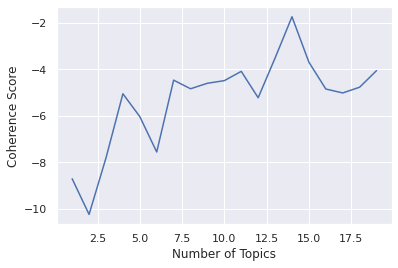

In [12]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()
